# **Reltery.com:** Desarrollo del modelo de inteligencia artificial

Giovanny Alfonso Chávez Ceniceros 310831<br/>
Luis Carlos Parra Mendoza 307718<br/><br/>

**28 de Mayo del 2021**

A continuación se presenta el desarrollo del modelo de inteligencia atifical basado en redes reuronales implementado en la aplicación **reltery.com**. Nuestro modelo basado en redes neuronales toma la aspectos fisicos y economicos de tu inmueble. Esta información será procesada por cada neurona de nuestra red para predecir en conjunto el valor que tu inmueble puede tener en el mercado, de forma rápida y confiable.

In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/gdrive")
!pwd
%cd "/content/gdrive/My Drive/DATASETS/PROJECT"

Mounted at /content/gdrive
/content
/content/gdrive/My Drive/DATASETS/PROJECT


## **Procedimiento**
Se implementaron los siguientes pasos para la confección de nuestro modelo de redes neuronales, del cual, después del entrenamiento

* **(1)** Preprocesamiento del dataset
* **(2)** Crear _pipeline_
* **(3)** Separar dataset en _train_ y _test_
* **(4)** Diseñar arquitectura del modelo
* **(5)** Entrenar el modelo y almacenar los pesos


### **Importando librerías**

In [ ]:
# generales
import pickle
import locale
import numpy as np
import pandas as pd
import tensorflow as tf

print('tensorflow version', tf.__version__)

tensorflow version 2.4.1


In [ ]:
# para preprocesamiento
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
# para el modelo de red neuronal
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
# para plotting:
from matplotlib import pyplot as plt

### **Extraer el dataset**

In [ ]:
df = pd.read_csv('base.csv')
df.head()

,REG1,REG2,REG3,REG4,REG5,REG6,REG7,REG8,REG9,Id,Eu,Cz,Ns,Rp,Ca,Nr,Nb,Sb,Ee,See,Tfr,Tfo,St,Cg,Ec,Cy,Ed,Eu.1,Sh,Ssh,Sv,Cus,$T,$C,Vt,Vo,Va,Vf,$M,$Mn,Vm,Vmn,Vco
0,1,75,75,5362,41568,41823,TEPORACA NO 8601,15 DE ENERO,0,3,4,2,1,2,1,2,1,1.0,0.0,1,12.20,20.00,244.00,2,3,1,84,756,75.55,75.55,75.55,0.310,634.0,3276.000,154696.00,247501.80,39210.96,441408.76,6288.990,5769.983,475133.19,435922.23,475000.0
1,1,111,115,5297,41415,41759,GABRIEL TEPORAME ANTES TEPORACA NO.2214,17 DE JUNIO,INFONAVIT,3,4,2,1,2,1,3,1,1.0,1.0,1,9.00,17.00,153.00,1,3,1,60,660,109.41,109.41,109.41,0.715,281.6,2576.000,43084.80,281840.16,0.00,324924.96,3201.491,3201.491,350275.12,350275.12,350000.0
2,1,63,63,5265,41331,41548,LULU CREEL MULLER NO.8010,17 DE JUNIO,INFONAVIT,3,4,2,1,2,1,3,1,1.0,0.0,2,10.64,17.37,197.09,1,3,1,240,480,116.09,116.09,116.09,0.589,712.0,2310.000,140328.08,268167.90,46728.48,455224.46,4303.370,3900.851,499578.22,452849.74,500000.0
3,1,42,42,5519,41954,41155,MAURICIO CORREDOR NO.8010,17 DE JUNIO,BANCO NACIONAL DEL EJERCITO,3,4,2,1,2,1,2,1,1.0,1.0,1,8.21,17.27,114.59,1,3,1,156,564,77.17,77.17,80.31,0.673,920.0,4646.338,105422.80,373147.37,34875.20,513445.37,5099.378,4647.451,393519.00,358643.80,393500.0
4,1,113,116,5332,41495,41354,TEPORACA NO.2200,17 DE JUNIO,INFONAVIT,3,4,2,1,2,1,2,1,1.0,1.0,1,8.00,17.00,134.30,1,3,1,60,660,98.30,98.30,98.30,0.732,713.0,3255.000,95755.90,319966.50,22104.20,437826.60,4470.700,4245.835,439469.81,417365.61,439000.0


### **Procesar los datos**
Se desarrollan herramientas especiales para el procesamiento de los datos a partir del objeto ```Pandas.DataFrame```:

In [ ]:
class Preprocessor:
  def __init__(self):
    # etiquetas del información del registro inmobiliario
    self.R = ['REG1', 'REG2', 'REG3', 'REG4', 'REG5', 'REG6', 'REG7', 'REG8', 'REG9']
    # etiquetas de los datos categoricos
    self.C = ['Id', 'Eu', 'Cz', 'Ns', 'Rp', 'Ca', 'Cg', 'Ec']
    # etiquetas de los datos numericos
    self.N = ['Nr', 'Nb', 'Sb', 'Ee', 'See', 'Tfr', 'Tfo', 'St', 'Cy', 'Ed', 'Eu.1',
              'Sh', 'Ssh', 'Sv', 'Cus', '$T', '$C', 'Vt', 'Vo', 'Va', 'Vf', '$M',
              '$Mn', 'Vm', 'Vmn']

  def retrieve(self, X):
    X.drop(self.R, axis=1, inplace=True)    
    y = pd.DataFrame(X['Vco'], columns=['Vco'])
    X.drop('Vco', axis=1, inplace=True)
    return X, y

  def drop_categories(self, X):
    X.drop(self.R + self.C, axis=1, inplace=True)
    y = pd.DataFrame(X['Vco'], columns=['Vco'])
    X.drop('Vco', axis=1, inplace=True)
    return X, y

  def drop_except(self, X, features):
    feats = [feat for feat in self.N if feat not in features]
    X.drop(self.R + self.C, axis=1, inplace=True)
    X.drop(feats, axis=1, inplace=True)
    y = pd.DataFrame(X['Vco'], columns=['Vco'])
    X.drop('Vco', axis=1, inplace=True)
    return X, y


De la totalidad de los features existentes en los datos, se seleccionan los más indicados considerando la usabilidad del lado del usuario y el rendimiento por parte del modelo a implementar:

### __Features__

* **Nr**:   numero de recamaras
* **Nb**:   numero de baños completos
* **Sb**:   suma de baños
* **Ee**:   estacionamiento descubiertos
* **See**:  suma de estacionamientos
* **Tfr**:  Tamaño del terreno en frente
* **Tfo**:  Tamaño del terremo en fondo
* **St**:   superficie del terreno en el estudio
* **Ed**:   edad aproximada de la construccion en meses
* **\$M**:  monto unitario aplicable para el valor de mercado
* **\$Mn**: monto unitario de mercado sin areas y elementos adicionales
* **Vm**:   valor comparatvo de mercado
* **Vmn**:  valor de mercado -Areas y elementos adicionales-

### __Target__
* **Vco**:  Valor concluido

In [ ]:
feats = ['Nr', 'Nb', 'Sb', 'Ee', 'See', 'Tfr', 'Tfo', 'St', 'Ed', '$M', '$Mn', 'Vm', 'Vmn']

In [ ]:
X, y = Preprocessor().drop_except(X=df.copy(), features=feats)
X.head()

,Nr,Nb,Sb,Ee,See,Tfr,Tfo,St,Ed,$M,$Mn,Vm,Vmn
0,2,1,1.0,0.0,1,12.20,20.00,244.00,84,6288.990,5769.983,475133.19,435922.23
1,3,1,1.0,1.0,1,9.00,17.00,153.00,60,3201.491,3201.491,350275.12,350275.12
2,3,1,1.0,0.0,2,10.64,17.37,197.09,240,4303.370,3900.851,499578.22,452849.74
3,2,1,1.0,1.0,1,8.21,17.27,114.59,156,5099.378,4647.451,393519.00,358643.80
4,2,1,1.0,1.0,1,8.00,17.00,134.30,60,4470.700,4245.835,439469.81,417365.61


In [ ]:
y.head()

,Vco
0,475000.0
1,350000.0
2,500000.0
3,393500.0
4,439000.0


### **Implementar un _pipeline_**

In [ ]:
numPipe = Pipeline([
  ('minMax', MinMaxScaler())
])

prep = ColumnTransformer(transformers=[
        ('num', numPipe, feats)
        ])

In [ ]:
_xTrain, _xTest, _yTrain, _yTest = train_test_split(X, y, test_size=0.2)

In [ ]:
# aplicamos el pipeline para ambas particiones del dataset
prepPipe = Pipeline([('prep', prep)])

xTrain = prepPipe.fit_transform(_xTrain)
xTest  = prepPipe.transform(_xTest)

In [ ]:
yTrain = np.array(_yTrain).ravel()
yTest  = np.array(_yTest).ravel()

In [ ]:
xTrain[:1]

array([[0.16666667, 0.        , 0.        , 0.        , 0.25      ,
        0.095625  , 0.26702435, 0.04929382, 0.26153846, 0.20203263,
        0.19029411, 0.05964024, 0.05581824]])

In [ ]:
xTest[:1]

array([[0.33333333, 0.25      , 0.33333333, 0.        , 0.5       ,
        0.171875  , 0.26826248, 0.08381998, 0.03076923, 0.4565158 ,
        0.44258609, 0.24435155, 0.23366256]])

### **Modelo de red neuronal para regresión**

In [ ]:
def MLP(dim, regress=False):
	# definir nuestro modelo
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))
	# verificar si se debe agregar el nodo de regresión
    if regress:
        model.add(Dense(1, activation="linear"))
	# regresar el modelo
    return model

### **Compilar y entrenar el modelo de red neuronal**

In [ ]:
model = MLP(xTrain.shape[1], regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt, metrics=['mae', 'mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 112       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# cargar un modelo previo para no realizar un entrenamiento desde cero
model.load_weights('MLP_WEIGHTS.h5')

In [ ]:
# entrenamos el modelo planteado
metrics = model.fit(x=xTrain, y=yTrain,
                    validation_data=(xTest, yTest),
                    epochs=10000,
                    batch_size=8,
                    verbose=1)

In [ ]:
# guardar el modelo de la red
model.save_weights('MLP_WEIGHTS.h5')

In [ ]:
jsonModel = model.to_json()
with open("MLP_MODEL.json", "w") as jsonFile:
    jsonFile.write(jsonModel)

### **Métricas de desempeño**

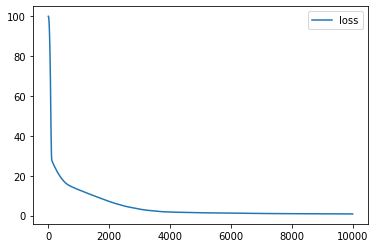

In [ ]:
plt.plot(metrics.history["loss"], label="loss")
plt.legend()

In [ ]:
hist = pd.DataFrame(metrics.history)
hist['epoch'] = metrics.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
9995,0.832373,6720.269043,577980928.0,1.002072,7689.338867,1.002929e+09,9995
9996,0.832439,6719.728516,577950272.0,1.001319,7680.969238,1.002332e+09,9996
9997,0.832221,6718.857422,578005056.0,1.001987,7688.701172,1.002904e+09,9997
9998,0.832194,6719.090820,577922560.0,1.001967,7688.647949,1.002906e+09,9998
9999,0.832147,6718.462402,577922432.0,1.001971,7689.000000,1.002929e+09,9999


In [ ]:
mlpPreds = model.predict(xTest)
mlpPreds[:5]

array([[ 523812.44],
       [ 493599.7 ],
       [1770074.4 ],
       [2854856.  ],
       [ 192145.47]], dtype=float32)

In [ ]:
diff = mlpPreds.flatten() - yTest
percentDiff = (diff / yTest) * 100
absPercentDiff = np.abs(percentDiff)

In [ ]:
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

In [ ]:
print('μ: {} σ: {}'.format(y.mean()[0], y.std()[0]))
print('μ: {} σ: {}'.format(mean, std))

μ: 716946.7244703511 σ: 600210.0883233249
μ: 0.7237254765350293 σ: 1.1117406669002527
